In [7]:
from IPython.display import Image, display
from dotenv import load_dotenv
import json
import os
import importlib
from langchain.prompts import SystemMessagePromptTemplate
from langchain_core.messages import AIMessage, SystemMessage, BaseMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, NotRequired, TypedDict


MODEL = "mistral-nemo"
TEMPERATURE = 0
load_dotenv("../.env", override=True)
# PATH_TO_FILE = os.path.abspath(__file__)


TOOL_REGISTRY = {
    "core.tools.builtins.calculator": ["multiply", "add", "divide"],
    "core.tools.builtins.wikipedia": ["query"],
}


def import_function(module_name, function_name):
    """Dynamically imports a function from a module.

    Args:
        module_name: The name of the module (e.g., "my_module").
        function_name: The name of the function to import (e.g., "my_function").

    Returns:
        The imported function, or None if the module or function is not found.
    """
    try:
        module = importlib.import_module(module_name)
        function = getattr(module, function_name)
        return function
    except (ImportError, AttributeError) as e:
        print(f"I'm in cwd: {os.getcwd()}")
        print(f"Available modules: {os.listdir(os.getcwd())}")
        print(
            f"Error: Could not import function '{function_name}' from module '{module_name}'."
        )
        print(f"Exception: {e}")
        return None


tools = [
    import_function(module, function)
    for module, functions in TOOL_REGISTRY.items()
    for function in functions
]


llm = ChatOllama(
    model=MODEL,
    temperature=TEMPERATURE,
    # base_url="http://host.docker.internal:11434", # if running in the studio
).bind_tools(tools)


class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    claim: str
    # {'name': tool name, 'args': {kwargs}, 'result': str}
    evidence: list[dict]


with open("prompts/research_agent_system_prompt.txt", "r") as f:
    sys_msg = SystemMessage(content=f.read())


def preprocessing(state: State):
    """
    Preprocesses state before sending to the assistant for tool routing.
    Currently, this just extracts the claim from the state and sets it as a HumanMessage
    following the SystemMessage
    """
    state["messages"] = [sys_msg, HumanMessage(content=state["claim"])]
    return state


def assistant(state: State) -> State:
    response = llm.invoke(state["messages"])
    return {"messages": response}


def postprocessing(state: State) -> State:
    """
    Scan the message history to extract tool calls and results into tuples:
    (tool_name, tool_args, tool_result) for the 'evidence' list in the state
    """

    evidence = []
    for i in range(len(state["messages"])):
        message = state["messages"][i]
        if isinstance(message, AIMessage) and hasattr(message, "tool_calls"):
            for tool_call in message.tool_calls:
                # Scan later messages for the corresponding ToolMessage
                for j in range(i + 1, len(state["messages"])):
                    next_message = state["messages"][j]
                    if (
                        isinstance(next_message, ToolMessage)
                        and next_message.tool_call_id == tool_call["id"]
                    ):
                        # Found the corresponding ToolMessage
                        evidence.append(
                            {
                                "name": tool_call["name"],
                                "args": tool_call["args"],
                                "result": next_message.content,
                            }
                        )
                        break

    return {"evidence": evidence}
    # return state


# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("preprocessing", preprocessing)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("postprocessing", postprocessing)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "preprocessing")
builder.add_edge("preprocessing", "assistant")
builder.add_conditional_edges(
    source="assistant",
    path=tools_condition,
    path_map={"tools": "tools", "__end__": "postprocessing"},
)
builder.add_edge("tools", "assistant")
builder.add_edge("postprocessing", END)

research_agent = builder.compile()
display(Image(research_agent.get_graph(xray=True).draw_mermaid_png()))

I'm in cwd: /Users/benjaminbasseri/Dropbox/Studies/Programming/asha/newsagent/core/agents
Available modules: ['agent_stub.py', 'tools', 'verdict_agent.py', 'nb_verdict_agent.ipynb', 'nb_research_agent.ipynb', '__init__.py', '__pycache__', 'langgraph.json', 'np_claim_decomposer.ipynb', 'reasoning_agent.py', 'nb_integration.ipynb', 'claim_decomposer.py', 'research_agent.py', 'prompts', 'nb_reasoning_agent.ipynb']
Error: Could not import function 'multiply' from module 'core.tools.builtins.calculator'.
Exception: No module named 'core'
I'm in cwd: /Users/benjaminbasseri/Dropbox/Studies/Programming/asha/newsagent/core/agents
Available modules: ['agent_stub.py', 'tools', 'verdict_agent.py', 'nb_verdict_agent.ipynb', 'nb_research_agent.ipynb', '__init__.py', '__pycache__', 'langgraph.json', 'np_claim_decomposer.ipynb', 'reasoning_agent.py', 'nb_integration.ipynb', 'claim_decomposer.py', 'research_agent.py', 'prompts', 'nb_reasoning_agent.ipynb']
Error: Could not import function 'add' from mo

ValueError: Unsupported function

None

Functions must be passed in as Dict, pydantic.BaseModel, or Callable. If they're a dict they must either be in OpenAI function format or valid JSON schema with top-level 'title' and 'description' keys.

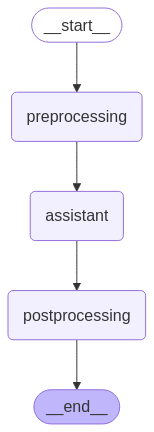

In [ ]:
"""
5. Build the graph
"""

builder = StateGraph(State)
builder.add_node("preprocessing", preprocessing)
builder.add_node("assistant", assistant)
builder.add_node("postprocessing", postprocessing)

builder.add_edge(START, "preprocessing")
builder.add_edge("preprocessing", "assistant")

builder.add_edge("assistant", "postprocessing")
builder.add_edge("postprocessing", END)
graph = builder.compile()

In [3]:
from langchain_core.messages import HumanMessage

claim = "George Washington was the first president of the United States."
evidence = [
    "George Washington was born in 1732.",
    "George Washington was a general in the Revolutionary War.",
    "George Washington was elected president in 1789.",
]
initial_state = {"claim": claim, "evidence": evidence}
final_state = graph.invoke(initial_state)

In [4]:
print(f"Label: {final_state['label']}")
print(f"Justification: {final_state['justification']}")
print("Messages:")
for m in final_state["messages"]:
    m.pretty_print()

Label: true
Justification: George Washington served as the first President of the United States, serving two terms from April 30, 1789, until his death on December 14, 1799.
Messages:
================================ Human Message =================================

George Washington was the first president of the United States.
================================== Ai Message ==================================

{ "label": "true" , "justification": "George Washington served as the first President of the United States, serving two terms from April 30, 1789, until his death on December 14, 1799." }
